Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75.

Столбец text в датасете содержит текст комментария, а toxic — целевой признак.

Описание данных

Данные находятся в файле toxic_comments.csv. Столбец text в нём содержит текст комментария, а toxic — целевой признак.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pymystem3 import Mystem
import re
import torch
from tqdm import notebook
from sklearn.utils import shuffle

In [56]:
df = pd.read_csv('toxic_comments.csv')
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [58]:
m = Mystem()

In [59]:
def preprocessing(text):
    t = re.sub(r'[^a-z]', ' ',text.lower())
    clear_text = " ".join(t.split())
    lemm_text = " ".join(m.lemmatize(clear_text))
    
    return lemm_text

Проверяем соотношение классов! 

In [60]:
print('Соотношение классов:')
class_balance = df['toxic'].value_counts()/len(df)
class_balance

Соотношение классов:


0    0.898321
1    0.101679
Name: toxic, dtype: float64

Как мы видим, наблюдается дисбаланс классов. Для его устранения при составлении моделей, необходимо использовать автокоррекцию весов классов или upsampling/downsampling.

In [61]:
df['lemm_text'] = df['text'].apply(lambda x: preprocessing(x))

In [62]:
df.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background c...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real sugge...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance y...


In [63]:
import nltk

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lubava/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [65]:
df = shuffle(df, random_state=54321)

In [67]:
X = df['lemm_text']
y = df['toxic']

corpus, corpus_test, y, y_test  = train_test_split(X, y, test_size=0.2, random_state=123)
corpus_train, corpus_valid, y_train, y_valid = train_test_split(corpus, y, test_size=0.25, random_state=123)

In [68]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
X_train = count_tf_idf.fit_transform(corpus_train)
X_valid = count_tf_idf.transform(corpus_valid)
X_test = count_tf_idf.transform(corpus_test)

In [69]:
print('Размер тестовой выборки:')
print(corpus_test.shape)

Размер тестовой выборки:
(31915,)


Таким образом, мы произвели разделение нашей выборки на тренировочную, валидационную и тестовую.
Далее рассмотрим разные модельки

In [70]:
from sklearn.ensemble import RandomForestClassifier

In [76]:
rfc = RandomForestClassifier(n_estimators=50,max_depth=5,class_weight='balanced' )

In [77]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [78]:
pred_rfc = rfc.predict(X_test)

In [79]:
from sklearn.metrics import classification_report

In [80]:
print(classification_report(pred_rfc,y_test))

              precision    recall  f1-score   support

           0       0.60      0.97      0.74     17831
           1       0.84      0.19      0.31     14084

    accuracy                           0.63     31915
   macro avg       0.72      0.58      0.53     31915
weighted avg       0.71      0.63      0.55     31915



In [81]:
from sklearn.model_selection import GridSearchCV

In [105]:
param_grid = {'n_estimators': [45, 50, 90], 
              'max_depth': [2, 3, 5, 10],
              'min_samples_split': [2, 3, 5]}

In [106]:
grid = GridSearchCV(rfc,param_grid, refit=True, verbose=3, n_jobs=1)

In [107]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] max_depth=2, min_samples_split=2, n_estimators=45 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=2, min_samples_split=2, n_estimators=45, score=0.546, total=   2.9s
[CV] max_depth=2, min_samples_split=2, n_estimators=45 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  max_depth=2, min_samples_split=2, n_estimators=45, score=0.573, total=   2.8s
[CV] max_depth=2, min_samples_split=2, n_estimators=45 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s


[CV]  max_depth=2, min_samples_split=2, n_estimators=45, score=0.587, total=   2.7s
[CV] max_depth=2, min_samples_split=2, n_estimators=45 ...............
[CV]  max_depth=2, min_samples_split=2, n_estimators=45, score=0.562, total=   2.7s
[CV] max_depth=2, min_samples_split=2, n_estimators=45 ...............
[CV]  max_depth=2, min_samples_split=2, n_estimators=45, score=0.583, total=   2.7s
[CV] max_depth=2, min_samples_split=2, n_estimators=50 ...............
[CV]  max_depth=2, min_samples_split=2, n_estimators=50, score=0.542, total=   3.0s
[CV] max_depth=2, min_samples_split=2, n_estimators=50 ...............
[CV]  max_depth=2, min_samples_split=2, n_estimators=50, score=0.591, total=   3.0s
[CV] max_depth=2, min_samples_split=2, n_estimators=50 ...............
[CV]  max_depth=2, min_samples_split=2, n_estimators=50, score=0.577, total=   3.1s
[CV] max_depth=2, min_samples_split=2, n_estimators=50 ...............
[CV]  max_depth=2, min_samples_split=2, n_estimators=50, score=0.591, 

[CV]  max_depth=3, min_samples_split=2, n_estimators=90, score=0.624, total=   7.7s
[CV] max_depth=3, min_samples_split=2, n_estimators=90 ...............
[CV]  max_depth=3, min_samples_split=2, n_estimators=90, score=0.651, total=   7.7s
[CV] max_depth=3, min_samples_split=2, n_estimators=90 ...............
[CV]  max_depth=3, min_samples_split=2, n_estimators=90, score=0.607, total=   7.8s
[CV] max_depth=3, min_samples_split=2, n_estimators=90 ...............
[CV]  max_depth=3, min_samples_split=2, n_estimators=90, score=0.677, total=   8.4s
[CV] max_depth=3, min_samples_split=2, n_estimators=90 ...............
[CV]  max_depth=3, min_samples_split=2, n_estimators=90, score=0.610, total=   8.1s
[CV] max_depth=3, min_samples_split=3, n_estimators=45 ...............
[CV]  max_depth=3, min_samples_split=3, n_estimators=45, score=0.636, total=   3.9s
[CV] max_depth=3, min_samples_split=3, n_estimators=45 ...............
[CV]  max_depth=3, min_samples_split=3, n_estimators=45, score=0.568, 

[CV]  max_depth=5, min_samples_split=3, n_estimators=45, score=0.630, total=   6.2s
[CV] max_depth=5, min_samples_split=3, n_estimators=45 ...............
[CV]  max_depth=5, min_samples_split=3, n_estimators=45, score=0.649, total=   6.7s
[CV] max_depth=5, min_samples_split=3, n_estimators=50 ...............
[CV]  max_depth=5, min_samples_split=3, n_estimators=50, score=0.615, total=   7.0s
[CV] max_depth=5, min_samples_split=3, n_estimators=50 ...............
[CV]  max_depth=5, min_samples_split=3, n_estimators=50, score=0.616, total=   7.3s
[CV] max_depth=5, min_samples_split=3, n_estimators=50 ...............
[CV]  max_depth=5, min_samples_split=3, n_estimators=50, score=0.580, total=   7.3s
[CV] max_depth=5, min_samples_split=3, n_estimators=50 ...............
[CV]  max_depth=5, min_samples_split=3, n_estimators=50, score=0.657, total=   7.1s
[CV] max_depth=5, min_samples_split=3, n_estimators=50 ...............
[CV]  max_depth=5, min_samples_split=3, n_estimators=50, score=0.626, 

[CV]  max_depth=10, min_samples_split=3, n_estimators=90, score=0.709, total=  24.3s
[CV] max_depth=10, min_samples_split=3, n_estimators=90 ..............
[CV]  max_depth=10, min_samples_split=3, n_estimators=90, score=0.667, total=  24.1s
[CV] max_depth=10, min_samples_split=3, n_estimators=90 ..............
[CV]  max_depth=10, min_samples_split=3, n_estimators=90, score=0.667, total=  23.9s
[CV] max_depth=10, min_samples_split=3, n_estimators=90 ..............
[CV]  max_depth=10, min_samples_split=3, n_estimators=90, score=0.709, total=  23.9s
[CV] max_depth=10, min_samples_split=5, n_estimators=45 ..............
[CV]  max_depth=10, min_samples_split=5, n_estimators=45, score=0.673, total=  12.3s
[CV] max_depth=10, min_samples_split=5, n_estimators=45 ..............
[CV]  max_depth=10, min_samples_split=5, n_estimators=45, score=0.660, total=  12.8s
[CV] max_depth=10, min_samples_split=5, n_estimators=45 ..............
[CV]  max_depth=10, min_samples_split=5, n_estimators=45, score=

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 26.2min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              oob_score=False,
                                              

In [109]:
grid.best_params_

{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 90}

In [110]:
grid.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [114]:
rfc = RandomForestClassifier(n_estimators = 90,max_depth = 10,min_samples_split = 5,class_weight='balanced',criterion='gini')

In [115]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [125]:
prediction_valid = rfc.predict(X_valid)

In [126]:
print(classification_report(prediction_valid,y_valid))

              precision    recall  f1-score   support

           0       0.70      0.98      0.81     20522
           1       0.85      0.24      0.37     11392

    accuracy                           0.71     31914
   macro avg       0.78      0.61      0.59     31914
weighted avg       0.75      0.71      0.66     31914



Теперь прогоним модельку через Логистическую регрессию

In [118]:
from sklearn.linear_model import LogisticRegression

In [120]:
logreg = LogisticRegression(class_weight = 'balanced', random_state=123)

In [121]:
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [127]:
pred_valid = logreg.predict(X_valid)

In [128]:
pred_test = logreg.predict(X_test)

In [129]:
print("Метрики на валидационной выборке:") 
print(classification_report(pred_valid, y_valid)) 
print("Метрики на тестовой выборке:") 
print(classification_report(pred_test,y_test))  

Метрики на валидационной выборке:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     27900
           1       0.83      0.66      0.74      4014

    accuracy                           0.94     31914
   macro avg       0.89      0.82      0.85     31914
weighted avg       0.94      0.94      0.94     31914

Метрики на тестовой выборке:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     27789
           1       0.85      0.66      0.75      4126

    accuracy                           0.94     31915
   macro avg       0.90      0.82      0.86     31915
weighted avg       0.94      0.94      0.94     31915



Теперь попробуем запустить градиентный бустинг и посмотрим на скор

In [130]:
from catboost import CatBoostClassifier  
 
model = CatBoostClassifier(
            iterations=500,
            random_seed = 123,
            metric_period = 50,
            verbose=50,
            eval_metric = 'F1',
            learning_rate = 0.5,
            early_stopping_rounds = 50)
 
model.fit(X_train, y_train)

prediction_valid = model.predict(X_valid)
prediction_test = model.predict(X_test)

print("Метрики на валидационной выборке:") 
print(classification_report(prediction_valid, y_valid)) 
print("Метрики на тестовой выборке:") 
print(classification_report(prediction_test,y_test))  

0:	learn: 0.4593028	total: 2.35s	remaining: 19m 32s
50:	learn: 0.7391758	total: 1m 1s	remaining: 8m 58s
100:	learn: 0.7823616	total: 2m 9s	remaining: 8m 31s
150:	learn: 0.8040312	total: 3m 10s	remaining: 7m 20s
200:	learn: 0.8231508	total: 4m 10s	remaining: 6m 12s
250:	learn: 0.8353721	total: 5m 2s	remaining: 5m
300:	learn: 0.8403304	total: 5m 56s	remaining: 3m 55s
350:	learn: 0.8446541	total: 6m 49s	remaining: 2m 53s
400:	learn: 0.8491582	total: 7m 41s	remaining: 1m 53s
450:	learn: 0.8530458	total: 8m 34s	remaining: 55.9s
499:	learn: 0.8572393	total: 9m 27s	remaining: 0us
Метрики на валидационной выборке:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     29474
           1       0.67      0.89      0.77      2440

    accuracy                           0.96     31914
   macro avg       0.83      0.92      0.87     31914
weighted avg       0.97      0.96      0.96     31914

Метрики на тестовой выборке:
              precision    rec

Делаем выводы ->

In [132]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import f1_score

In [139]:
print('F1 метрика на тестовой выборке:', round(f1_score(prediction_test, y_test),2))

F1 метрика на тестовой выборке: 0.77


In [140]:
probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

In [146]:
auc_roc = roc_auc_score(y_test, probabilities_one_test)

In [152]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

<Figure size 864x1152 with 0 Axes>

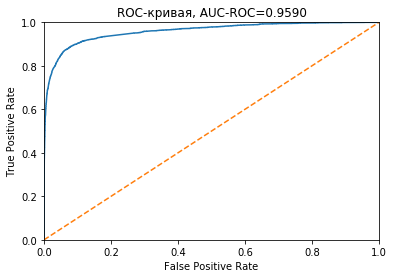

F1 метрика на тестовой выборке: 0.77


In [154]:
plt.figure(figsize=(12,16))
plt.figure()
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая, AUC-ROC=' + "{0:.4f}".format(auc_roc))
plt.show()

print('F1 метрика на тестовой выборке:', round(f1_score(prediction_test, y_test),2))

ROC кривая должна располагаться над диагональной линией, в таком случае это сигнализирует нам о том, что мы выбрали хорошую модель.  Чем сильнее roc кривая стремится к верхнему левому углу, тем лучше. 
Таким образом, цель задания достигнута . Модели, на основе градиентного бустинга (CatBoost) и логистической регрессии достигли требуемого установленного уровня F1-метрики в 0.75.